In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample
from mne.minimum_norm import make_inverse_operator, apply_inverse
import sys; sys.path.insert(0, '../')
from esinet.forward import create_forward_model, get_info
import os
from dipoleDataset import DipoleDataset
from util import eeg_to_Epochs
import torch
from esinet.evaluate import eval_auc, eval_nmse, eval_mse, eval_mean_localization_error
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#reading the forward solution
fs = 100
info = get_info(sfreq=fs)
fwd = create_forward_model(sampling='ico4', info=info)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  80 | elapsed:    4.4s remaining:   15.3s
[Parallel(n_jobs=-1)]: Done  35 out of  80 | elapsed:    4.6s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  52 out of  80 | elapsed:    4.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  69 out of  80 | elapsed:    4.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  80 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  35 out of  80 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  52 out of  80 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  69 out of  80 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80

In [3]:
data_dir = "/mnt/data/convdip/training_data/"
eeg_data_dir = os.path.join(data_dir, "eeg_data")
interp_data_dir = os.path.join(data_dir, "interp_data")
source_data_dir = os.path.join(data_dir, "source_data")
info_path = os.path.join(data_dir, "info.fif")
dataset = DipoleDataset(eeg_data_dir, interp_data_dir, source_data_dir, info_path)
test_size = 0.15
val_size = 0.15

test_amount, val_amount = int(dataset.__len__() * test_size), int(dataset.__len__() * val_size)

# this function will automatically randomly split your dataset but you could also implement the split yourself
gen = torch.Generator()
gen.manual_seed(0)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [
            (dataset.__len__() - (test_amount + val_amount)), 
            test_amount, 
            val_amount
])

B = 512  # batch size
train_dataloader = torch.utils.data.DataLoader(
            train_set,
            batch_size=B,
            shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=B,
            shuffle=True,
)
test_dataloader = torch.utils.data.DataLoader(
            test_set,
            batch_size=B,
            shuffle=True,
)

In [4]:
dipole_pos = np.load(os.path.join(data_dir, "dipole_pos.npy"))

In [5]:
eeg_trials = []
targets = []
idxs = []
for i, data in enumerate(test_dataloader.dataset):
    idx, _, target = data
    eeg_trials.append(np.load(os.path.join(eeg_data_dir,f"sample_{idx}.npy")))
    idxs.append(idx)
    targets.append(target)
    if i == 40:
        break
epochs = eeg_to_Epochs(eeg_trials, None, info)


In [ ]:
epochs[0].get_data(copy=False).squeeze().shape

(61, 100)

In [6]:
noise_cov = mne.compute_covariance(
    epochs, tmax=40, method='auto', rank=None, verbose=True)

#fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, info)

    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 61 -> 60
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 4100
log-likelihood on unseen data (descending order):
   shrunk: -310.304
   diagonal_fixed: -316.298
   empirical: -342.415
selecting best estimator: shrunk
[done]


In [58]:
evoked = epochs[1].average()

In [12]:
method = "eLORETA"
snr = 3.
lambda2 = 1. / snr ** 2

metrics_per_sample = {}
metric_save_path = "/mnt/data/convdip/eLORETA_evaluation_metrics.json"

for i in range(len(epochs)):
    evoked = epochs[i].average()
    inverse_operator = make_inverse_operator(
        evoked.info, fwd, noise_cov, fixed=True, depth=0)
    stc, residual = apply_inverse(evoked, inverse_operator, lambda2,
                              method=method, pick_ori=None,
                              return_residual=True, verbose=True)
    eeg = epochs[i].get_data(copy=False).squeeze()
    target = np.array(targets[i])
    
    max_idx = np.unravel_index(np.argmax(eeg), eeg.shape)[1] # this is the timestep with the maximum eeg value, this will be used to train
    s_at_max = stc.data[:,max_idx]

    auc_close, auc_far = eval_auc(target, s_at_max, dipole_pos)
    sample_auc = (auc_close + auc_far)/2
    
    mle = eval_mean_localization_error(target, s_at_max, dipole_pos)
    mse = eval_mse(target, s_at_max)
    nmse = eval_nmse(target, s_at_max)
    metrics_per_sample[idxs[i]] = [auc_close, auc_far, mle, mse, nmse]

    if i % 512 == 0:
        with open(metric_save_path, "w") as json_file:
            json.dump(metrics_per_sample, json_file)

Computing inverse operator with 61 channels.
    61 out of 61 channels remain after picking


Selected 61 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 8.7e-11 (2.2e-16 eps * 61 dim * 6.4e+03  max singular value)
    Estimated rank (eeg): 60
    EEG: rank 60 computed from 61 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 2.89679
    scaling factor to adjust the trace = 8.31038e+16 (nchan = 61 nzero = 1)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 60 (1 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Fitting up t

KeyboardInterrupt: 

In [59]:
#Creating the inverse operator
inverse_operator = make_inverse_operator(
    evoked.info, fwd, noise_cov, fixed=True, depth=0)
#del fwd

# You can write it to disk with::
#
#     >>> from mne.minimum_norm import write_inverse_operator
#     >>> write_inverse_operator('sample_audvis-meg-oct-6-inv.fif',
#                                inverse_operator)

Computing inverse operator with 61 channels.
    61 out of 61 channels remain after picking
Selected 61 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 9.4e-11 (2.2e-16 eps * 61 dim * 6.9e+03  max singular value)
    Estimated rank (eeg): 60
    EEG: rank 60 computed from 61 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 2.38835
    scaling factor to adjust the trace = 6.01634e+16 (nchan = 61 nzero = 1)


In [60]:
#computing solution
method = "eLORETA"
snr = 3.
lambda2 = 1. / snr ** 2
stc, residual = apply_inverse(evoked, inverse_operator, lambda2,
                              method=method, pick_ori=None,
                              return_residual=True, verbose=True)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 60 (1 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Fitting up to 20 iterations...
        Converged on iteration 11 (5.2e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Applying inverse operator to "1"...
    Picked 61 channels from the data
    Computing inverse...
    Eigenleads already weighted ... 
    Computing residual...
    Explained  75.6% variance
[done]


In [61]:
stc.data.shape

(5124, 100)

[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'eLORETA value')]

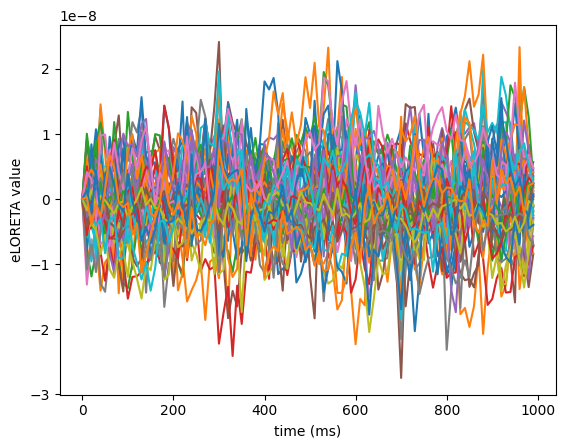

In [62]:
#Visualization
fig, ax = plt.subplots()
ax.plot(1e3 * stc.times, stc.data[::100, :].T)
ax.set(xlabel='time (ms)', ylabel='%s value' % method)

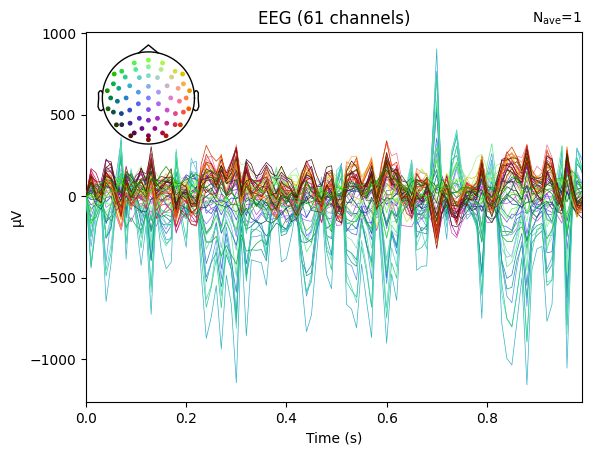

TypeError: 'Axes' object is not iterable

In [63]:
#original and residual data after fitting
fig, axes = plt.subplots(1, 1)
evoked.plot(axes=axes)
for ax in axes:
    for text in list(ax.texts):
        text.remove()
    for line in ax.lines:
        line.set_color('#98df81')
residual.plot(axes=axes)

In [ ]:
#Better/more visualization
vertno_max, time_max = stc.get_peak(hemi='rh')

subjects_dir = data_path / 'subjects'
surfer_kwargs = dict(
    hemi='rh', subjects_dir=subjects_dir,
    clim=dict(kind='value', lims=[8, 12, 15]), views='lateral',
    initial_time=time_max, time_unit='s', size=(800, 800), smoothing_steps=10)
brain = stc.plot(**surfer_kwargs)
brain.add_foci(vertno_max, coords_as_verts=True, hemi='rh', color='blue',
               scale_factor=0.6, alpha=0.5)
brain.add_text(0.1, 0.9, 'dSPM (plus location of maximal activation)', 'title',
               font_size=14)

# The documentation website's movie is generated with:
# brain.save_movie(..., tmin=0.05, tmax=0.15, interpolation='linear',
#                  time_dilation=20, framerate=10, time_viewer=True)